# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
 -1
  1
 -1
 -1
 -1
 -1
  1
 -1
 -1
  ⋮
  1
 -1
 -1
 -1
  1
 -1
 -1
 -1
 -1

### We create a function to visualize the data

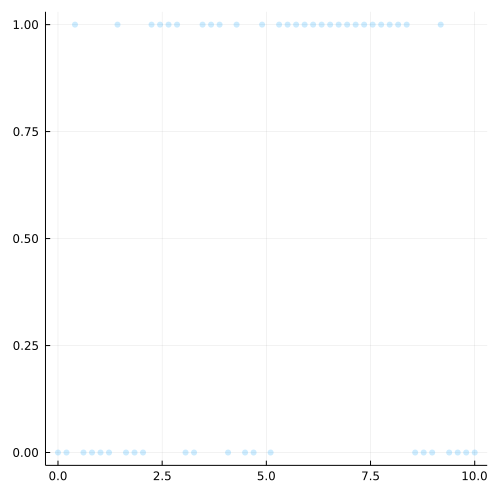

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.947981 seconds (1.85 M allocations: 98.383 MiB, 99.57% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [1.0308158762526018, 1.0583968376346011, 1.0827862238329695, 1.0946409826255652, 1.0843054734407511, 1.0450832171417068, 0.9751067328694673, 0.8792999574872941, 0.771327495580881, 0.6733293136919032  …  0.9450246744963958, 0.727969316120383, 0.6108003003053233, 0.6461028058289552, 0.7835186383295002, 0.9412852272040008, 1.0746094311925145, 1.1657860357525986, 1.2121225158182511, 1.2193257364040262], θ = [0.2299867952631412, 0.22901056682488918, 0.22813449477070188, 0.2277044666157879, 0.22807953592310556, 0.22948375864886109, 0.231909184201702, 0.23504736048877936, 0.2383008368777468, 0.24096418144785328  …  0.23291825696584223, 0.2395148958002755, 0.24250698584120553, 0.24165148466094105, 0.23794962368566458, 0.23304221490307145, 0.22842951710025142, 0.2250691545411327, 0.22330604766003

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:04:50
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:28
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:38
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:13
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:00:58
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:49
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:41
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:36
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:32
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:29
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:26
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:24
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.5595680181926331, -0.7068578637467606, -0.7751232815603926, -0.7688498920003781, -0.649194136768702, -0.4555056204130078, -0.19297735951022904, 0.09196276948486326, 0.3190660035737056, 0.5226792142199547  …  1.2327371198039314, 0.8662337213846808, 0.4037834898279313, -0.13388079884782317, -0.6641393798158599, -1.123939603737907, -1.4419317853047673, -1.616501692178547, -1.6187679726415194, -1.4715835097329117]]
 [[-0.834743553060517, -0.7103570518587488, -0.6508480631680775, -0.6687351394372866, -0.7598863787567479, -0.8833930277866172, -0.9652741348466615, -0.9721044995024477, -0.8954691144006126, -0.7366936636093092  …  0.5848133136652708, 0.3829518551122555, 0.16904288566823805, -0.01974405147856728, -0.18839911244414698, -0.32232263927257404, -0.4699603485273319, -0.5834117513763002, -0.7269640974828244, -0.8439782693966646]]
 [[-0.6880556253189685, -0.6623433548385013, -0.6224217054446892, -0.6224806878778868, -0.5683246862528735

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

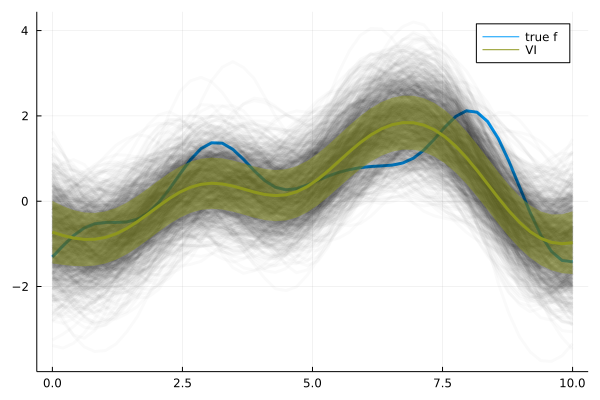

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

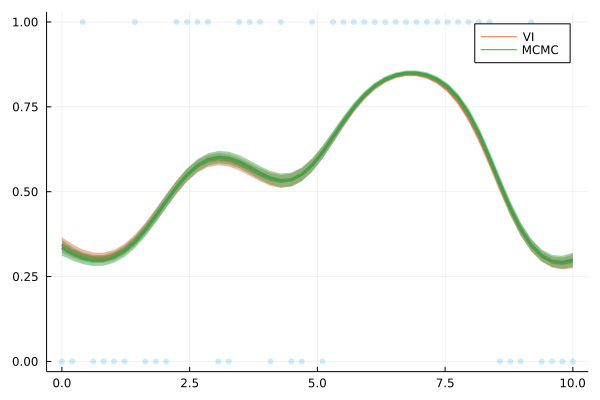

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*